In [101]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score

In [140]:
data = pd.read_csv('../dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       866 non-null    float64
 1   sex       866 non-null    float64
 2   cp        866 non-null    float64
 3   trestbps  809 non-null    float64
 4   chol      840 non-null    float64
 5   fbs       784 non-null    float64
 6   restecg   865 non-null    float64
 7   thalach   811 non-null    float64
 8   exang     811 non-null    float64
 9   oldpeak   806 non-null    float64
 10  slope     570 non-null    float64
 11  ca        297 non-null    float64
 12  thal      413 non-null    float64
 13  label     866 non-null    int64  
 14  split     866 non-null    object 
dtypes: float64(13), int64(1), object(1)
memory usage: 101.6+ KB


## Data preprocessing

In [141]:

# Eliminamos filas duplicadas
data = data.drop_duplicates()

# Definimos variables categóricas y numéricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = ['label']

# Parseamos las variables categóricas como enteros, para eliminar los decimales, y luego las pasamos a string, para que su valor 
# numérico no influya en el análisis ni en las predicciones
data[categorical_vars + target] = data[categorical_vars + target].astype(float).astype('Int64')
data[categorical_vars + target] = data[categorical_vars + target].astype(str)
# ca = 9 es un oulier, lo clippeamos a 3, que es el valor máximo según las especificaciones
data['ca'] = data['ca'].replace('9', '3')

# Reemplazamos 0s en chol y trestbps con NAs
data[['trestbps', 'chol']] = data[['trestbps', 'chol']].replace(0, np.nan)

# Rellenamos los valores numéricos no informados
# data[numerical_vars ] = data[numerical_vars].replace(pd.NA, np.nan)
imputer = KNNImputer(missing_values=np.nan, n_neighbors=8)
data[numerical_vars + target] = imputer.fit_transform(data[numerical_vars + target])

# Clippeamos los outliers
for var in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = data[var][data[var] > 0].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    cut_off = iqr * 1.5
    lower, upper = q1 - cut_off, q3 + cut_off
    data.loc[data[var] > upper, var] = upper
    data.loc[data[var] < lower, var] = lower
    
# Para oldpeak no filtramos valores negativos, ya que son posibles
#tmp_data = data['oldpeak'].dropna()
#q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
#iqr = q3 - q1
#cut_off = iqr * 1.5
#lower, upper = q1 - cut_off, q3 + cut_off
#data.loc[data['oldpeak'] > upper, 'oldpeak'] = upper
#data.loc[data['oldpeak'] < lower, 'oldpeak'] = lower

In [142]:
X = data.drop(['label', 'split'], axis=1)


In [143]:
y = data['label'].astype(int)

In [144]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 865
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       865 non-null    float64
 1   sex       865 non-null    object 
 2   cp        865 non-null    object 
 3   trestbps  865 non-null    float64
 4   chol      865 non-null    float64
 5   fbs       865 non-null    object 
 6   restecg   865 non-null    object 
 7   thalach   865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   865 non-null    float64
 10  slope     865 non-null    object 
 11  ca        865 non-null    object 
 12  thal      865 non-null    object 
dtypes: float64(5), object(8)
memory usage: 94.6+ KB


In [145]:
# Escalamos los datos numéricos para que se ajusten a una distribución normal
X[numerical_vars] = scale(X[numerical_vars])

X[numerical_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 865
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       865 non-null    float64
 1   trestbps  865 non-null    float64
 2   chol      865 non-null    float64
 3   thalach   865 non-null    float64
 4   oldpeak   865 non-null    float64
dtypes: float64(5)
memory usage: 40.5 KB


In [146]:
# ahora aplicamos OHE a las variables categóricas
ohe = OneHotEncoder(drop= 'first', sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = ohe_fit.get_feature_names_out()

X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
X.set_index('index')
X.drop('index', axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex_1         865 non-null    float64
 1   cp_2          865 non-null    float64
 2   cp_3          865 non-null    float64
 3   cp_4          865 non-null    float64
 4   fbs_1         865 non-null    float64
 5   fbs_<NA>      865 non-null    float64
 6   restecg_1     865 non-null    float64
 7   restecg_2     865 non-null    float64
 8   restecg_<NA>  865 non-null    float64
 9   exang_1       865 non-null    float64
 10  exang_<NA>    865 non-null    float64
 11  slope_2       865 non-null    float64
 12  slope_3       865 non-null    float64
 13  slope_<NA>    865 non-null    float64
 14  ca_1          865 non-null    float64
 15  ca_2          865 non-null    float64
 16  ca_3          865 non-null    float64
 17  ca_<NA>       865 non-null    float64
 18  thal_6        865 non-null    

In [172]:
counts = data['split'].value_counts()

{ n: round(100 * val / sum(counts.values), 2) for n, val in counts.items() }

{'train': 79.88, 'val': 20.12}

In [173]:
counts

train    691
val      174
Name: split, dtype: int64

In [148]:
counts = y.value_counts()

print(counts) 

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

0    399
1    185
3    125
2    123
4     33
Name: label, dtype: int64


{0: 100.0, 1: 46.37, 3: 31.33, 2: 30.83, 4: 8.27}

In [149]:
# Como tenemos muy pocos datos de la clase 4, vamos a hacer oversampling para que esté más balanceado, 
# doblando el número de muestras de esta clase, de 33 a 66

sm = SMOTE(sampling_strategy={4: 120}, random_state = 1, k_neighbors = 7)
X, y = sm.fit_resample(X, y)

In [150]:
counts = y.value_counts()

{ n: round(100 * val / counts[0], 2) for n, val in counts.items() }

{0: 100.0, 1: 46.37, 3: 31.33, 2: 30.83, 4: 30.08}

## Test dataset

Tenemos que aplicar las mismas transformaciones al test dataset

In [170]:
X_test = pd.read_csv('../test_dataset.csv')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       50 non-null     float64
 1   sex       50 non-null     float64
 2   cp        50 non-null     float64
 3   trestbps  48 non-null     float64
 4   chol      46 non-null     float64
 5   fbs       43 non-null     float64
 6   restecg   49 non-null     float64
 7   thalach   50 non-null     float64
 8   exang     50 non-null     float64
 9   oldpeak   48 non-null     float64
 10  slope     38 non-null     float64
 11  ca        12 non-null     float64
 12  thal      20 non-null     float64
dtypes: float64(13)
memory usage: 5.2 KB


In [171]:
X_test[numerical_vars].describe()

,age,trestbps,chol,thalach,oldpeak
count,50.000000,48.000000,46.000000,50.00000,48.000000
mean,55.120000,132.979167,194.086957,134.94000,1.366667
std,7.922172,18.014757,130.567109,22.18421,1.280514
min,35.000000,94.000000,0.000000,92.00000,0.000000
25%,50.000000,120.000000,38.250000,120.00000,0.000000
50%,56.000000,130.000000,222.000000,140.00000,1.100000
75%,61.000000,140.500000,278.250000,150.00000,2.125000
max,76.000000,190.000000,491.000000,179.00000,5.000000


In [152]:
# Parseamos las variables categóricas como enteros, para eliminar los decimales, y luego las pasamos a string, para que su valor 
# numérico no influya en el análisis ni en las predicciones
X_test[categorical_vars] = X_test[categorical_vars].astype(float).astype('Int64')
X_test[categorical_vars] = X_test[categorical_vars].astype(str)

# Reemplazamos 0s en chol y trestbps con NAs
X_test[['trestbps', 'chol']] = X_test[['trestbps', 'chol']].replace(0, np.nan)

# Rellenamos los valores numéricos no informados
X_test[numerical_vars] = X_test[numerical_vars].replace(pd.NA, np.nan)
imputer = KNNImputer(missing_values=np.nan, n_neighbors=8)
X_test[numerical_vars] = imputer.fit_transform(X_test[numerical_vars])

# Clippeamos los outliers
for var in ['trestbps', 'chol', 'thalach', 'oldpeak']:
    tmp_data = X_test[var][X_test[var] > 0].dropna()
    q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
    iqr = q3 - q1
    cut_off = iqr * 1.5
    lower, upper = q1 - cut_off, q3 + cut_off
    X_test.loc[X_test[var] > upper, var] = upper
    X_test.loc[X_test[var] < lower, var] = lower
    
# Para oldpeak no filtramos valores negativos, ya que son posibles
# tmp_data = data['oldpeak'].dropna()
# q1, q3 = np.quantile(tmp_data, 0.25), np.quantile(tmp_data, 0.75)
# iqr = q3 - q1
# cut_off = iqr * 1.5
# lower, upper = q1 - cut_off, q3 + cut_off
# data.loc[data['oldpeak'] > upper, 'oldpeak'] = upper
# data.loc[data['oldpeak'] < lower, 'oldpeak'] = lower

In [153]:
X_test[numerical_vars] = scale(X_test[numerical_vars])

ohe = OneHotEncoder(drop= 'first', sparse = False)
ohe_fit = ohe.fit(X_test[categorical_vars])
X_test_ohe = pd.DataFrame(ohe.fit_transform(X_test[categorical_vars]))
X_test_ohe.columns = ohe_fit.get_feature_names_out()

X_test = pd.concat((X_test_ohe, X_test[numerical_vars].reset_index()), axis=1)
X_test.set_index('index')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex_1         50 non-null     float64
 1   cp_2          50 non-null     float64
 2   cp_3          50 non-null     float64
 3   cp_4          50 non-null     float64
 4   fbs_1         50 non-null     float64
 5   fbs_<NA>      50 non-null     float64
 6   restecg_1     50 non-null     float64
 7   restecg_2     50 non-null     float64
 8   restecg_<NA>  50 non-null     float64
 9   exang_1       50 non-null     float64
 10  slope_2       50 non-null     float64
 11  slope_3       50 non-null     float64
 12  slope_<NA>    50 non-null     float64
 13  ca_1          50 non-null     float64
 14  ca_2          50 non-null     float64
 15  ca_3          50 non-null     float64
 16  ca_<NA>       50 non-null     float64
 17  thal_6        50 non-null     float64
 18  thal_7        50 non-null     fl

In [154]:
X_test.drop('index', axis=1, inplace=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex_1         50 non-null     float64
 1   cp_2          50 non-null     float64
 2   cp_3          50 non-null     float64
 3   cp_4          50 non-null     float64
 4   fbs_1         50 non-null     float64
 5   fbs_<NA>      50 non-null     float64
 6   restecg_1     50 non-null     float64
 7   restecg_2     50 non-null     float64
 8   restecg_<NA>  50 non-null     float64
 9   exang_1       50 non-null     float64
 10  slope_2       50 non-null     float64
 11  slope_3       50 non-null     float64
 12  slope_<NA>    50 non-null     float64
 13  ca_1          50 non-null     float64
 14  ca_2          50 non-null     float64
 15  ca_3          50 non-null     float64
 16  ca_<NA>       50 non-null     float64
 17  thal_6        50 non-null     float64
 18  thal_7        50 non-null     fl

In [155]:
X_test['exang_<NA>'] = 0

## KNN Classifier

In [156]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier as KNC


In [157]:
def kfold_test(model, n_splits, X, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_score =[]
    for train_idx, val_idx in kf.split(X, y):
        x_tr, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        #model
        model.fit(x_tr,y_tr)
        score_f1 = f1_score(y_val, model.predict(x_val), average='micro')
        cv_score.append(score_f1)

    return cv_score

def grid_search(model, params, X, y, n_splits = 5, n_jobs = 8, scoring = 'f1_micro'):
    grid = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring=scoring,
                        cv=n_splits, 
                        verbose=1,
                        n_jobs=n_jobs)
    grid.fit(X, y)
    print(f'Best params : {grid.best_params_}')
    print(f'Best score: {grid.best_score_}')
    return grid

In [158]:
model_knn = KNC()

In [165]:
params = {
'weights': ['uniform', 'distance'],
'n_neighbors': list(range(1, 21)), 
# 'algorithm': ['ball_tree', 'brute', 'kd_tree'], # 
'leaf_size': [8, 9, 10, 11],
'metric': ['euclidean',  'cosine', 'manhattan'] # 
}

grid = grid_search(model_knn, params, X, y)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best params : {'leaf_size': 8, 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.6029539818131717


In [160]:
params = {
'weights': ['uniform', 'distance'],
'n_neighbors': list(range(1, 21)), 
# 'algorithm': ['ball_tree', 'brute', 'kd_tree'], # 
# 'leaf_size': [10, 20, 30],
'metric': ['euclidean',  'cosine', 'manhattan'] # 
}

grid = grid_search(model_knn, params, X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params : {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.6029539818131717


In [79]:
params = {
'weights': ['uniform', 'distance'],
'n_neighbors': list(range(1, 21)), 
'algorithm': ['ball_tree', 'brute', 'kd_tree'], # 
'leaf_size': [10, 15, 20, 25, 30],
'metric': ['euclidean',  'manhattan'] # 'cosine',
}

ggrid = grid_search(model_knn, params, X, y)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best params : {'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.6029539818131717


In [169]:
best_config = grid.best_params_

model_knn = KNC(n_neighbors = best_config['n_neighbors'], 
               metric = best_config['metric'],
               weights = best_config['weights'],
               n_jobs = 7)


print(f"F1 score (train): {f1_score(y, pred_y, average='micro')}")

f1_scores = kfold_test(model_knn, 10, X, y)

print(f"F1 score 10-fold: {np.mean(f1_scores)}")

F1 score (train): 1.0
F1 score 10-fold: 0.5997368421052631


In [168]:
pred_y_test = model_knn.predict(X_test[X.columns.to_list()])
pred_df = pd.DataFrame({'ID': X_test.index.values, 'label': pred_y_test.astype(int)})
pred_df.to_csv('../submission_knn.csv', index=False)

!head '../submission_knn.csv'

ID,label
0,0
1,1
2,2
3,0
4,4
5,4
6,4
7,3
8,1


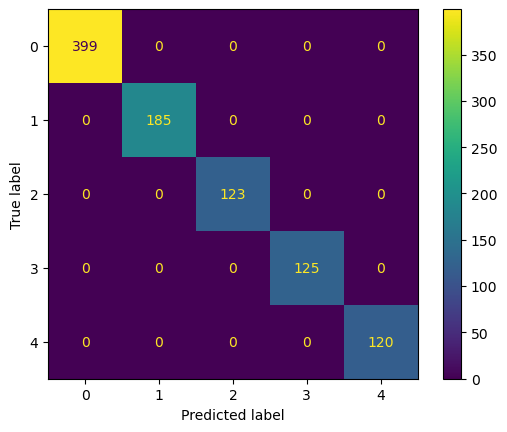

In [163]:
conf_matrix = confusion_matrix(y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_knn.classes_)
disp.plot()